# Introduction to Portfolio Theory: Benchmark #

Our dear friend Nancy is now happy because, fortunately, we were in the universe where she chose Nvidia for her first investment in 2018. But now she is questioning herself: “Did I choose the best investment from all the possible investments?” She goes to Thomas again, and he recommends that she look for a benchmark to compare her Nvidia investment against the market.

Now she is confused again: What is a benchmark, then? And how can she select the proper one?

In [26]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Statistics
from scipy.stats import skew, kurtosis
from scipy.stats import jarque_bera
from scipy.stats import probplot
from scipy.stats import norm

# Visualization
import matplotlib.pyplot as plt

# Handle Files
import sys
import os

# Import Local Functions
sys.path.append(os.path.abspath("../source"))
from config import get_tickers
from data_downloader import get_market_data

In [27]:
tickers = get_tickers(mod="1.2")

tickers

['^GSPC', '^DJI', '^NDX', 'IWY']

In [33]:
# DataFrame to store everything
benchmark_prices = pd.DataFrame()

for ticker in tickers:
    df = get_market_data(
        ticker=ticker, 
        start_date='2010-01-01', 
        end_date='2025-01-01', 
        returns=False
    )
    
    prices = df['close'].rename(ticker)
    
    benchmark_prices = pd.concat([benchmark_prices, prices], axis=1)
    
    print(f'Data Ready for {ticker}')

Data Ready for ^GSPC
Data Ready for ^DJI
Data Ready for ^NDX
Data Ready for IWY


In [34]:
benchmark_prices

,^GSPC,^DJI,^NDX,IWY
2010-01-04 00:00:00,1132.989990,10583.959961,1886.699951,22.601864
2010-01-05 00:00:00,1136.520020,10572.019531,1888.430054,22.494041
2010-01-06 00:00:00,1137.140015,10573.679688,1878.420044,22.560394
2010-01-07 00:00:00,1141.689941,10606.860352,1876.719971,22.469154
2010-01-08 00:00:00,1144.979980,10618.190430,1892.589966,22.552092
...,...,...,...,...
2024-12-24 00:00:00,6040.040039,43297.031250,21797.650391,243.511627
2024-12-26 00:00:00,6037.589844,43325.800781,21768.310547,243.072540
2024-12-27 00:00:00,5970.839844,42992.210938,21473.019531,239.530090
2024-12-30 00:00:00,5906.939941,42573.730469,21197.089844,236.636261


In [35]:
# Calculate Logarithmic Returns
def log_returns(
        price_series: pd.Series
):
    return np.log(price_series / price_series.shift(1))

In [37]:
# Calculate the Returns
benchmark_returns = log_returns(benchmark_prices)
benchmark_returns.dropna(inplace=True)

benchmark_returns

,^GSPC,^DJI,^NDX,IWY
2010-01-05 00:00:00,0.003111,-0.001129,0.000917,-0.004782
2010-01-06 00:00:00,0.000545,0.000157,-0.005315,0.002945
2010-01-07 00:00:00,0.003993,0.003133,-0.000905,-0.004052
2010-01-08 00:00:00,0.002878,0.001068,0.008421,0.003684
2010-01-11 00:00:00,0.001745,0.004304,-0.003361,0.002572
...,...,...,...,...
2024-12-24 00:00:00,0.010982,0.009050,0.013602,0.013657
2024-12-26 00:00:00,-0.000406,0.000664,-0.001347,-0.001805
2024-12-27 00:00:00,-0.011117,-0.007729,-0.013658,-0.014681
2024-12-30 00:00:00,-0.010760,-0.009782,-0.012933,-0.012155


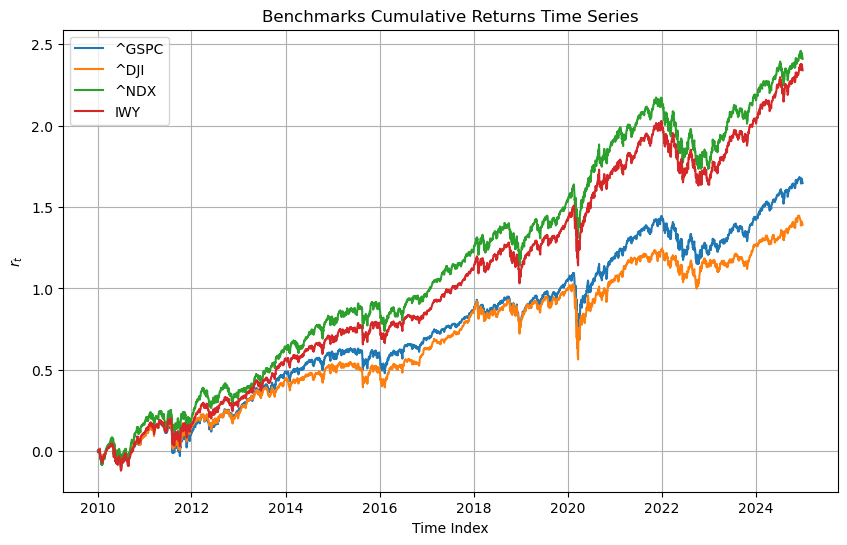

In [38]:
# Time Series Graphs
plt.figure(figsize=(10, 6))
plt.plot(benchmark_returns.cumsum(), label=benchmark_returns.columns, alpha=1)

# Config
plt.title('Benchmarks Cumulative Returns Time Series')
plt.xlabel('Time Index')
plt.ylabel('$r_t$')
plt.legend()

# Show
plt.grid(True)
plt.show()

In [39]:
# Check Daily
benchmark_returns.mul(100).mean()

^GSPC    0.043652
^DJI     0.036873
^NDX     0.063882
IWY      0.062035
dtype: float64

In [40]:
# Check Annualized Returns
benchmark_returns.mul(100).mean() * 252

^GSPC    11.000196
^DJI      9.291903
^NDX     16.098295
IWY      15.632782
dtype: float64

In [41]:
# Check Daily Volatility
benchmark_returns.mul(100).std()

^GSPC    1.088854
^DJI     1.049280
^NDX     1.302932
IWY      1.179526
dtype: float64

In [42]:
# Check Annualized Volatility
benchmark_returns.mul(100).std() * np.sqrt(252)

^GSPC    17.285017
^DJI     16.656802
^NDX     20.683402
IWY      18.724402
dtype: float64

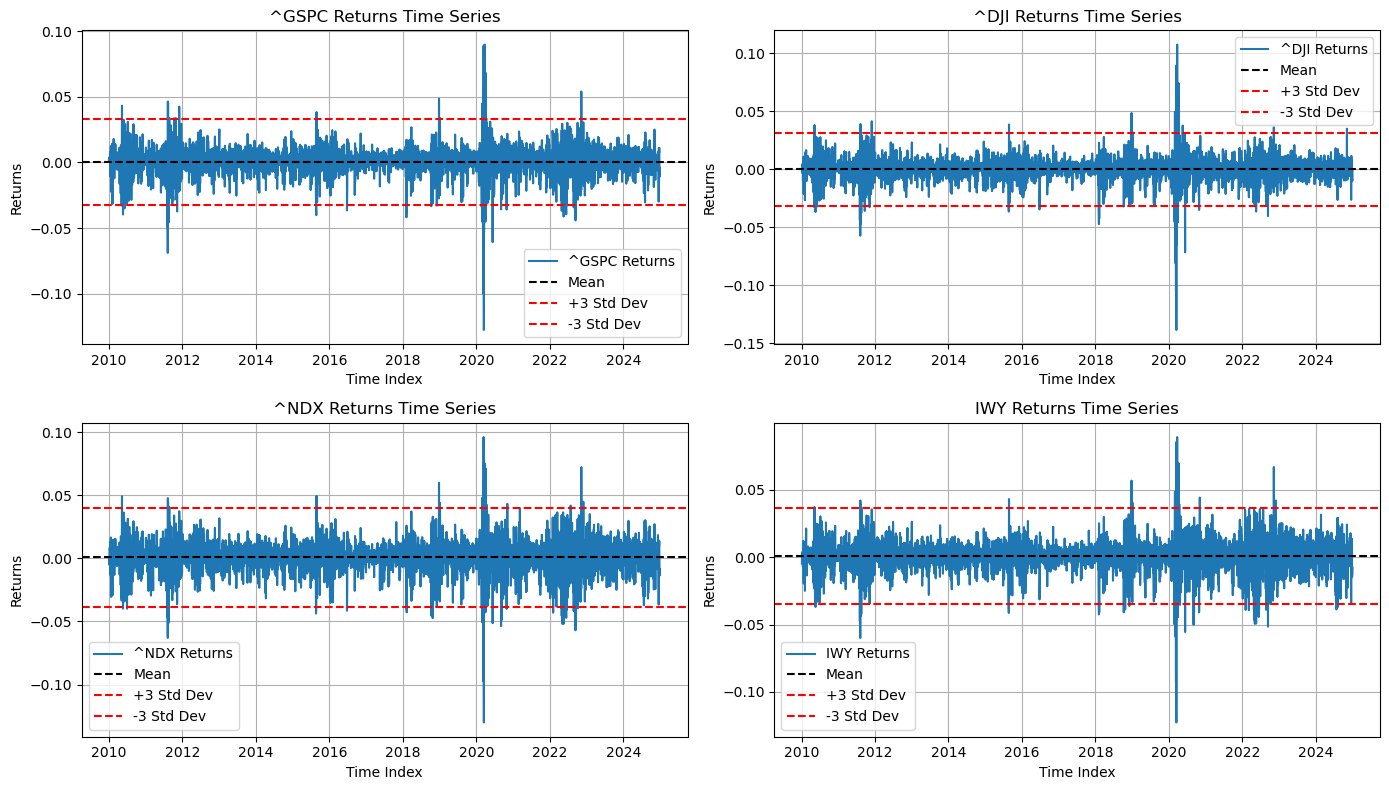

In [43]:
# Set the number of subplot columns
n_cols = 2
n_rows = int(np.ceil(len(benchmark_returns.columns) / n_cols))

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
axes = axes.flatten()  # Flatten to 1D array

# Loop through each column and plot
for i, column in enumerate(benchmark_returns.columns):
    data = benchmark_returns[column].dropna()
    mean = data.mean()
    std = data.std()
    upper_lim = mean + 3 * std
    lower_lim = mean - 3 * std

    axes[i].plot(data, label=f'{column} Returns', alpha=1)
    axes[i].axhline(y=mean, color='black', linestyle='dashed', label='Mean')
    axes[i].axhline(y=upper_lim, color='red', linestyle='dashed', label='+3 Std Dev')
    axes[i].axhline(y=lower_lim, color='red', linestyle='dashed', label='-3 Std Dev')

    axes[i].set_title(f'{column} Returns Time Series')
    axes[i].set_xlabel('Time Index')
    axes[i].set_ylabel('Returns')
    axes[i].legend()
    axes[i].grid(True)

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

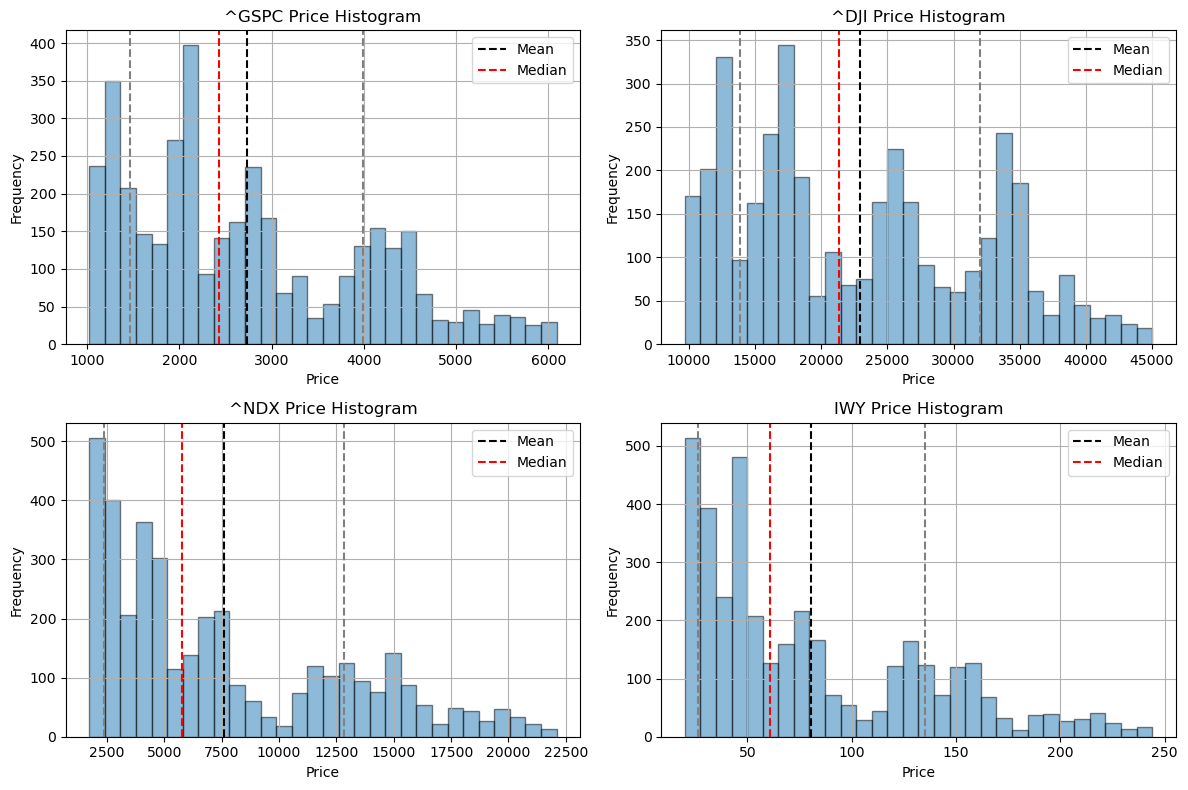

In [44]:
# Create figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()  # Flatten in case of 1D

# Plot each column
for i, column in enumerate(benchmark_prices.columns):
    data = benchmark_prices[column].dropna()
    mean_p = data.mean()
    median_p = data.median()
    std_p = data.std()
    upper_lim_p = mean_p + std_p
    lower_lim_p = mean_p - std_p

    axes[i].hist(data, bins=30, alpha=0.5, edgecolor='black')
    axes[i].axvline(x=mean_p, color='black', linestyle='dashed', label='Mean')
    axes[i].axvline(x=median_p, color='red', linestyle='dashed', label='Median')
    axes[i].axvline(x=upper_lim_p, color='grey', linestyle='dashed')
    axes[i].axvline(x=lower_lim_p, color='grey', linestyle='dashed')
    
    axes[i].set_title(f'{column} Price Histogram')
    axes[i].set_xlabel('Price')
    axes[i].set_ylabel('Frequency')
    axes[i].legend()
    axes[i].grid(True)

# Hide any unused subplots if columns < rows*cols
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

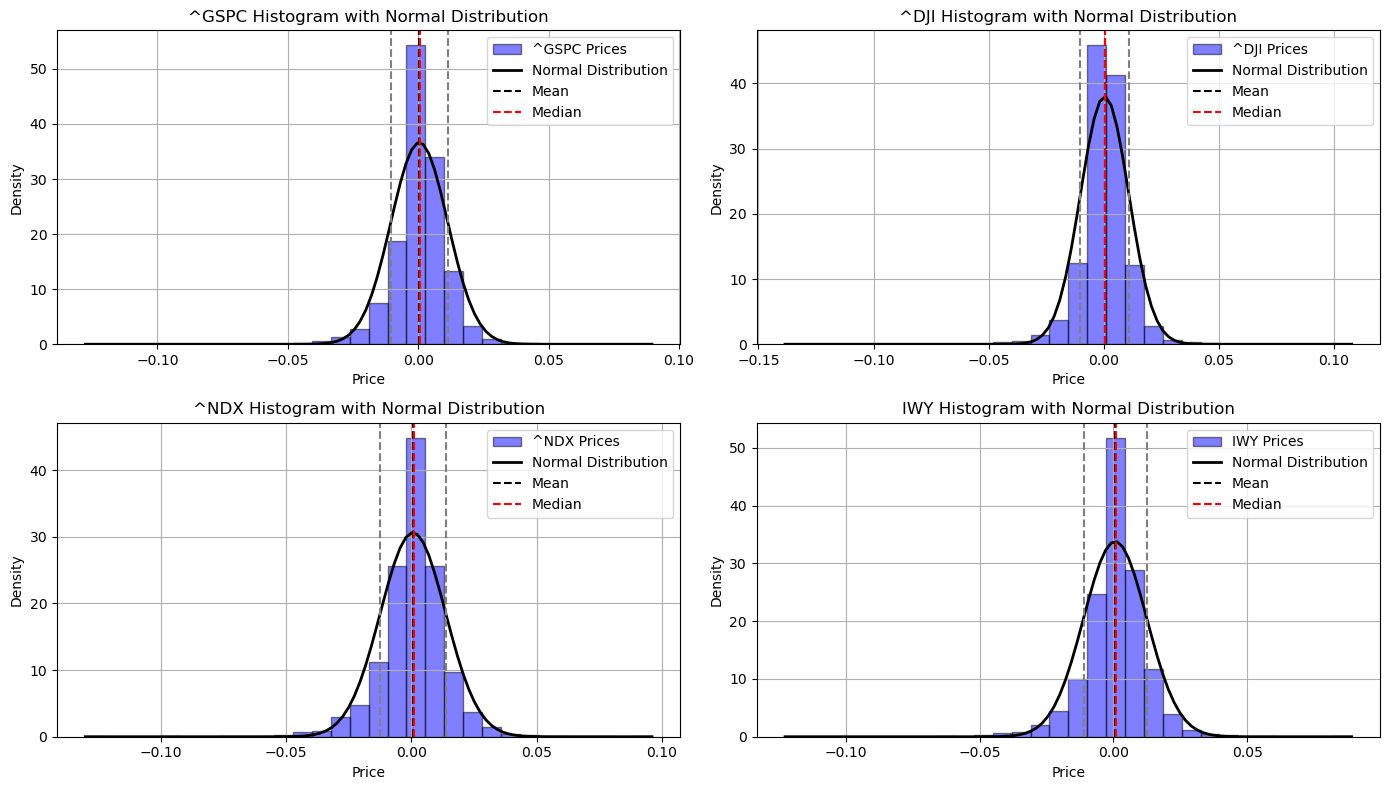

In [45]:
# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
axes = axes.flatten()

# Loop through each column
for i, column in enumerate(benchmark_returns.columns):
    data = benchmark_returns[column].dropna()
    mu = data.mean()
    sigma = data.std()

    # Histogram
    axes[i].hist(data, bins=30, density=True, color='blue', alpha=0.5, edgecolor='black', label=f'{column} Prices')

    # Normal distribution curve
    x = np.linspace(data.min(), data.max(), 100)
    y = norm.pdf(x, mu, sigma)
    axes[i].plot(x, y, color='black', linestyle='solid', linewidth=2, label='Normal Distribution')

    # Reference lines
    axes[i].axvline(x=mu, color='black', linestyle='dashed', label='Mean')
    axes[i].axvline(x=data.median(), color='red', linestyle='dashed', label='Median')
    axes[i].axvline(x=mu + sigma, color='grey', linestyle='dashed')
    axes[i].axvline(x=mu - sigma, color='grey', linestyle='dashed')

    # Titles and labels
    axes[i].set_title(f'{column} Histogram with Normal Distribution')
    axes[i].set_xlabel('Price')
    axes[i].set_ylabel('Density')
    axes[i].legend()
    axes[i].grid(True)

# Remove any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

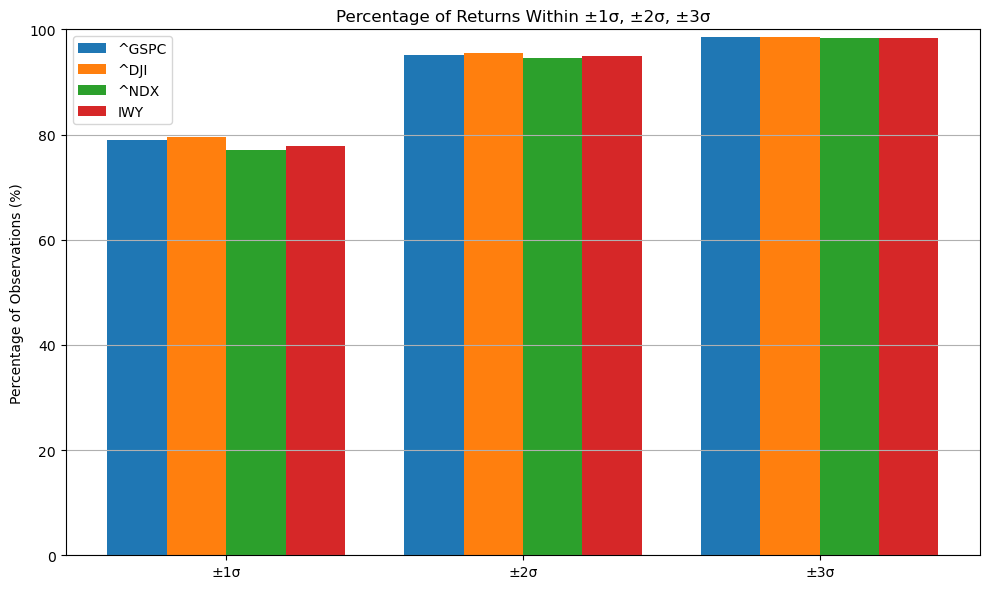

In [46]:
# Define the std ranges to analyze
std_ranges = [1, 2, 3]
benchmark_cols = benchmark_returns.columns
results = {col: [] for col in benchmark_cols}

# Calculate the percentage of returns within each std range
for col in benchmark_cols:
    data = benchmark_returns[col].dropna()
    mean = data.mean()
    std = data.std()
    
    for s in std_ranges:
        lower = mean - s * std
        upper = mean + s * std
        pct = ((data >= lower) & (data <= upper)).mean() * 100
        results[col].append(pct)

# Plotting
x = np.arange(len(std_ranges))
bar_width = 0.2

plt.figure(figsize=(10, 6))

for i, col in enumerate(benchmark_cols):
    plt.bar(x + i*bar_width, results[col], width=bar_width, label=col)

plt.xticks(x + bar_width * (len(benchmark_cols) - 1) / 2, [f'±{s}σ' for s in std_ranges])
plt.ylim(0, 100)
plt.ylabel('Percentage of Observations (%)')
plt.title('Percentage of Returns Within ±1σ, ±2σ, ±3σ')
plt.legend()
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()

In [47]:
# For some purposes of this course, we are selecting the SP500

# Calculate Mean
mean = benchmark_returns['^GSPC'].dropna().mean()

# Calculate Variance
variance = benchmark_returns['^GSPC'].dropna().var()

# Calculate Skewness
skewness = skew(benchmark_returns['^GSPC'].dropna())

# Calculate Kurtosis
kurt = kurtosis(benchmark_returns['^GSPC'].dropna())

print(f"Mean: {mean}")
print(f"Variance: {variance}")
print(f"Skewness: {skewness}")
print(f"Kurtosis: {kurt}")

Mean: 0.0004365157082407825
Variance: 0.00011856024022996067
Skewness: -0.7256260986128921
Kurtosis: 13.197679923977798


In [48]:
# Normality Test
jb_stat, p_value = jarque_bera(benchmark_returns['^GSPC'].dropna())

print(f"Jarque-Bera Stat: {jb_stat}")
print(f"p-value: {p_value}")

Jarque-Bera Stat: 27713.453483967038
p-value: 0.0


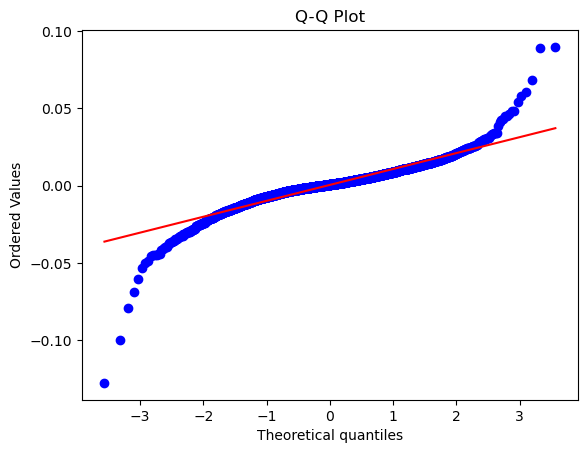

In [49]:
# Prices QQ Plot
probplot(benchmark_returns['^GSPC'], dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

In [51]:
# Store the Benchmark
benchmark = benchmark_returns['^GSPC']
benchmark.name = 'sp_500'
benchmark.index.name = 'date'

benchmark

date
2010-01-05    0.003111
2010-01-06    0.000545
2010-01-07    0.003993
2010-01-08    0.002878
2010-01-11    0.001745
                ...   
2024-12-24    0.010982
2024-12-26   -0.000406
2024-12-27   -0.011117
2024-12-30   -0.010760
2024-12-31   -0.004294
Name: sp_500, Length: 3773, dtype: float64

In [52]:
benchmark.to_csv(r"..\additional_data\sp500.csv")